In [1]:
import gurobipy as gpy

s = [10, 20, 5, 15, 10]
d = [5, 4, 7, 8, 5, 5]
c = [[500, 350, 250, 1300, 1400, 750],
     [600, 200, 500, 1400, 850, 900],
     [250, 1400, 175, 300, 500, 400],
     [1400, 875, 1000, 1100, 900, 1400],
     [1000, 450, 1400, 900, 300, 800]]
    
num_c = len(c)
num_dc = len(c[0])

m = gpy.Model('Truckload') 

m.ModelSense = gpy.GRB.MINIMIZE

x = [[m.addVar(vtype=gpy.GRB.CONTINUOUS, name=f'x_{i}_{j}') for j in range(num_dc)] for i in range(num_c)]

m.setObjective(gpy.quicksum(c[i][j]*x[i][j] for i in range(num_c) for j in range(num_dc)))
m.update()

m.addConstrs(gpy.quicksum(x[i][j] for j in range(num_dc)) <= s[i] for i in range(num_c))
m.addConstrs(gpy.quicksum(x[i][j] for i in range(num_c)) == d[j] for j in range(num_dc))
m.update()

m.optimize()

print(f'Total Cost (thousands): {m.objVal}')
for v in m.getVars():
    print(f'{v.varName}: {v.x}')

Restricted license - for non-production use only - expires 2026-11-23
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-4770 CPU @ 3.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 11 rows, 30 columns and 60 nonzeros
Model fingerprint: 0xa5dcd6d5
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+02, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 2e+01]
Presolve time: 0.01s
Presolved: 11 rows, 30 columns, 60 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.1750000e+03   2.000000e+01   0.000000e+00      0s
       6    1.5100000e+04   0.000000e+00   0.000000e+00      0s

Solved in 6 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.510000000e+04
Total Cost (thousands): 15100.0
x_0_0: 0.0
x_0_1: 0.0
x_0_2: 7.0
x_0_3: 0.0
x_0_4: 0.0

In [2]:
import matplotlib.pyplot as plt
import networkx as nx

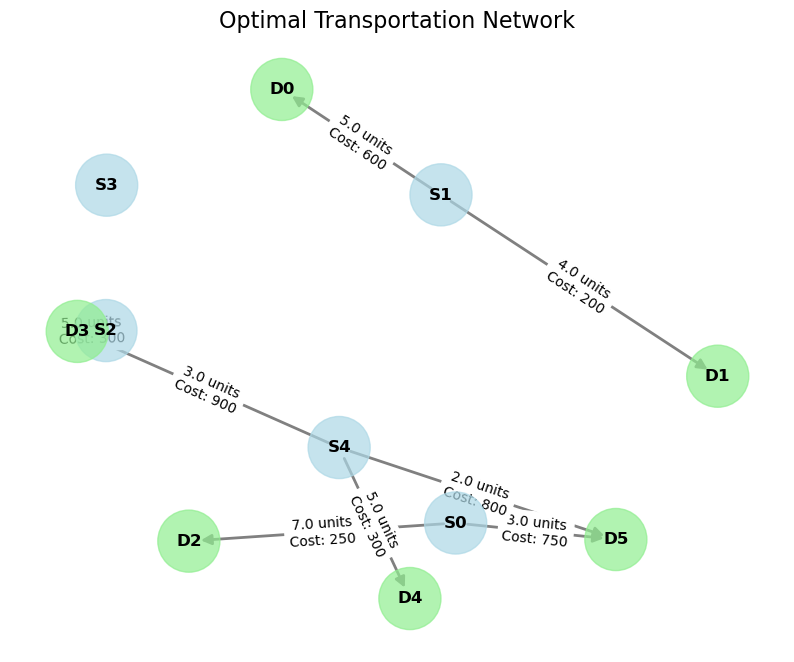

Total Transportation Cost: 15100.0
x_0_2: 7.00 units
x_0_5: 3.00 units
x_1_0: 5.00 units
x_1_1: 4.00 units
x_2_3: 5.00 units
x_4_3: 3.00 units
x_4_4: 5.00 units
x_4_5: 2.00 units


In [3]:
# Create a directed graph to visualize the transportation network
G = nx.DiGraph()

# Add nodes for supply and demand
for i in range(num_c):
    G.add_node(f'S{i}', node_type='supply', supply=s[i])  # Supply node

for j in range(num_dc):
    G.add_node(f'D{j}', node_type='demand', demand=d[j])  # Demand node

# Add edges with weights (costs) and flow values (amount of goods transported)
for i in range(num_c):
    for j in range(num_dc):
        flow_value = x[i][j].x  # Amount transported
        if flow_value > 0:  # Only add edges where goods are being transported
            G.add_edge(f'S{i}', f'D{j}', weight=c[i][j], flow=flow_value)

# Draw the network with edge labels for costs and flows
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)  # Layout for positioning nodes

# Draw nodes
node_colors = ['lightblue' if G.nodes[node]['node_type'] == 'supply' else 'lightgreen' for node in G]
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=2000, alpha=0.7)

# Draw edges
edges = G.edges(data=True)
nx.draw_networkx_edges(G, pos, edgelist=edges, arrowstyle='-|>', arrowsize=15, width=2, edge_color='gray')

# Draw labels for nodes
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

# Draw edge labels for flow values
edge_labels = {(u, v): f'{d["flow"]} units\nCost: {d["weight"]}' for u, v, d in edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

# Title and display
plt.title("Optimal Transportation Network", fontsize=16)
plt.axis('off')  # Hide the axis for better presentation
plt.show()

# Print the results
print(f"Total Transportation Cost: {m.objVal}")
for v in m.getVars():
    if v.x > 0:  # Only print flows where goods are transported
        print(f"{v.varName}: {v.x:.2f} units")